# Portfolio Project - Exploratory Data Analysis & PCA of Scania Truck APS System Dataset
### Michael Kenny - https://kennymichael.github.io/Michael-Kenny/

## Scenario:

In this project I perform data preparation and analysis of data collected from Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The dataset’s  positive class consists of component failures for a specific component of the APS system.

The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts. The goal of this analysis is to demonstrate dimensionality reduction and feature extraction techniques, establish the minimum number of features needed for retaining 99.5% variance in the data, and implement PCA to dimensionally reduce the data to the minimum number of features required. 

The data for this project was sourced from the UCI Machine Learning Repository - https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

## Importing Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.utils import Bunch
from sklearn.preprocessing import MinMaxScaler

First we are going to import our dataset using pandas, and save it to the variable scania_df as a pandas dataframe. The pandas tail and head methods provide us with a quick view of the data, in this step we are primarily trying to get an idea of its layout.

In [2]:
scania_df = pd.read_csv('aps_failure_set.csv')
scania_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [3]:
scania_df.tail()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
59995,neg,153002,na,664,186,0,0,0,0,0,...,998500,566884,1290398,1218244,1019768,717762,898642,28588,0,0
59996,neg,2286,na,2130706538,224,0,0,0,0,0,...,10578,6760,21126,68424,136,0,0,0,0,0
59997,neg,112,0,2130706432,18,0,0,0,0,0,...,792,386,452,144,146,2622,0,0,0,0
59998,neg,80292,na,2130706432,494,0,0,0,0,0,...,699352,222654,347378,225724,194440,165070,802280,388422,0,0
59999,neg,40222,na,698,628,0,0,0,0,0,...,440066,183200,344546,254068,225148,158304,170384,158,0,0


In [4]:
scania_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


From examining the data we can see it is made up of 60,000 rows with 171 feature columns each. Each row corresponds to a Scania truck, and each column is an anonymised components.

We can also see from the head and tail methods, that there are a number of missing values in the data. Missing data can skew our analysis, and prevent us from being able to perform numerical operations. Handling these missing values will be the first step in our preparation.

The package NumPy comes with a number of methods for dealing with missing values, that use the NumPy constant 'NaN'. Some of the missing values are currently denoted with a string 'na'. To utilise these methods we must first convert them to NaN values. Other common substitutes for NaN include '?', 'n.a.' and 'n/a' so we can check for and replace these too.

In [5]:
scania_df = scania_df.replace(['na', '?', 'n.a.', 'n/a'], np.NaN) # replacing na values with with Nan

In [6]:
na_count = scania_df.isna().sum().sum()
print(f'There are {na_count} NaN values in our dataframe.')

There are 850015 NaN values in our dataframe.


We have a total of 850,015 NaN values in our dataframe. To get an idea of the dispersion of the missing values, we can count the number of missing values in each column, and plot them on a bar chart.

Text(0.5, 1.0, 'Number of Missing Values Per Column in Scania Dataframe')

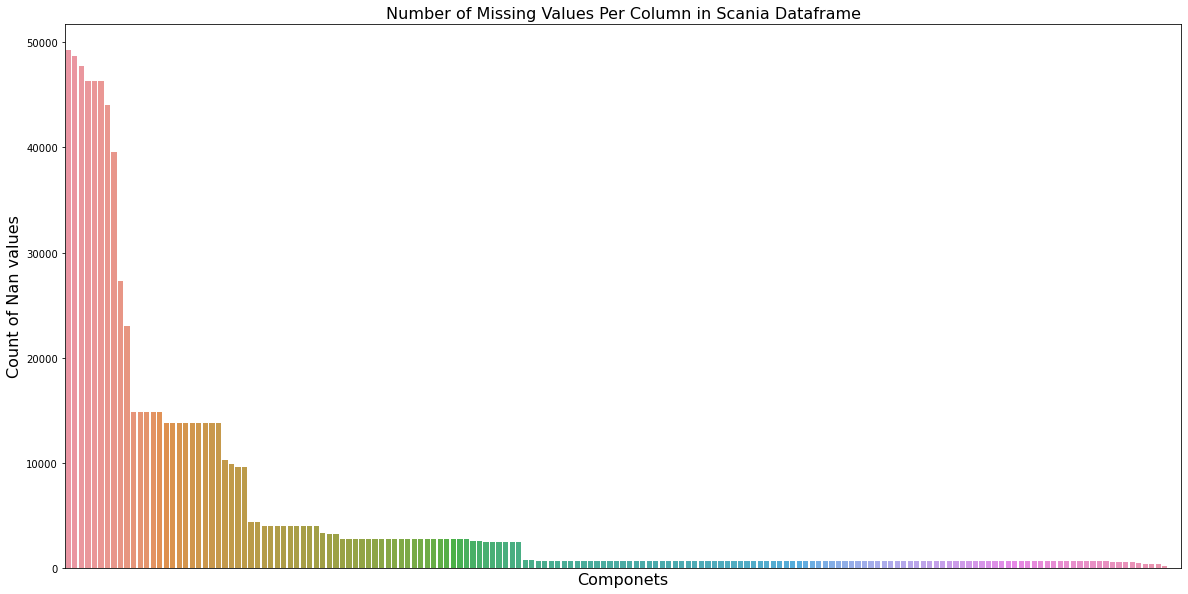

In [7]:
missing_values = scania_df.isna().sum().sort_values(ascending=False) # ccounting missing values in each column, and sorting in order

fig1, ax1 = plt.subplots(figsize=(20,10)) # setting the size of the chart
ax1 = sns.barplot(y = missing_values, x = missing_values.index, ax = ax1) # creating seaborn barchart
ax1.set_xticks([]) # removing x tick labels
ax1.set_xlabel('Componets', fontsize = 16) # labelling x axis
ax1.set_ylabel('Count of Nan values', fontsize = 16) # labelling y axis
ax1.set_title('Number of Missing Values Per Column in Scania Dataframe', fontsize = 16) # titling bar chart

From the bar chart we can see that the majority of NaN values are centred around a small subset of the columns in our dataframe, shown by the grouping of high bars to the left of the chart. We can greatly reduce the number of NaN values in our dataframe while retaining most of our data by dropping these columns. We want to drop as many NaN values as possible, while retaining as much of our data as we can. To start we can try dropping columns with 75% or more missing values.

In [8]:
total_values = 60000 # total number of rows in dataset
nan_percent = 0.75 # 75% or more Nan will be dropped
max_nans = total_values * nan_percent # maximum number of nans per columns
cols_to_drop = missing_values[:] > max_nans # checking the Nan count vs the maximum to keep
print(f'There are {cols_to_drop.sum()} columns with a percentage of NaN values above 75%.')

There are 6 columns with a percentage of NaN values above 75%.


We can mark on our graph the point at which we are dropping columns and visualize the difference in NaN values between the columns dropped and the columns to keep.

Text(10, 15500.0, 'Cut off point for NaN values')

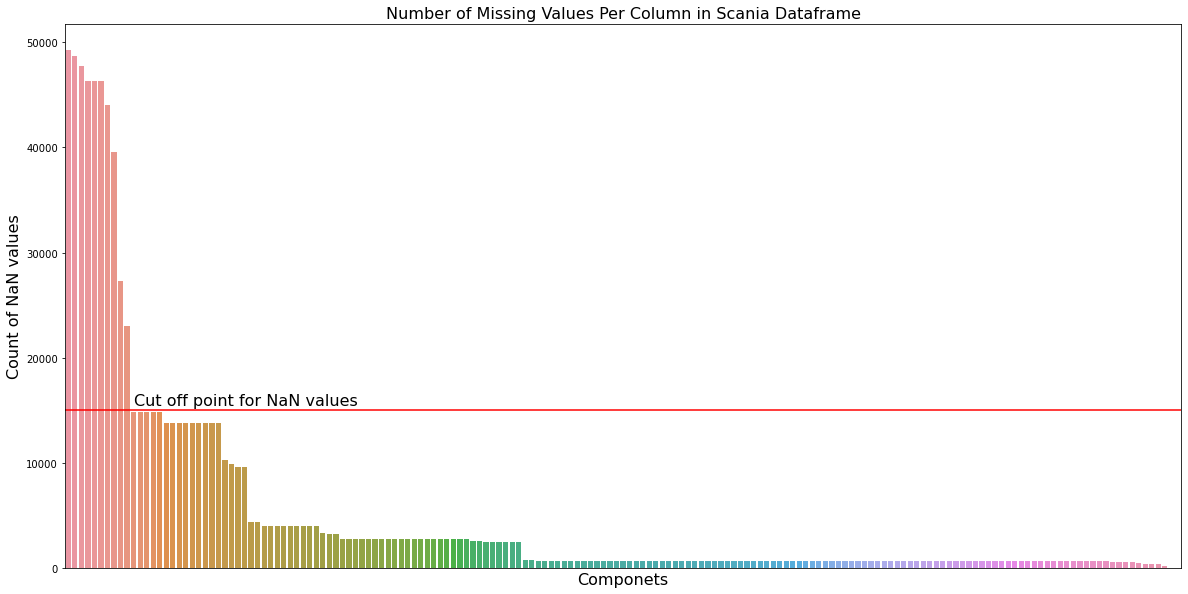

In [9]:
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1 = sns.barplot(y = missing_values, x = missing_values.index, ax = ax1)
ax1.set_xticks([])
ax1.set_xlabel('Componets', fontsize = 16)
ax1.set_ylabel('Count of NaN values', fontsize = 16)
ax1.set_title('Number of Missing Values Per Column in Scania Dataframe', fontsize = 16)

missing_percent = 60000 * 0.25 # defining max allowable NaN
ax1.axhline(missing_percent, color =  'r', xmin = 0) # labelling cut off point for missing values
ax1.text(10, missing_percent + 500, 'Cut off point for NaN values', rotation = 0, fontsize = 16) # labelling line

From our graph we can see we are dropping any columns with a NaN count above the red line. We can see there is a large difference in the number of NaN values in columns above and below the line. From this we can determine that 75% or more missing values looks to be a reasonable cut off point, as we are retaining most of our columns, and only removing strong outliers.

The next step is to drop the columns with a count of NaN values of 75% or more from our dataframe. Our previously defined cols_to_drop variable can be used as a boolean mask to drop those columns from our dataframe.

In [10]:
cols_to_drop.value_counts() # count of the columns to keep and to drop from our dataframe

False    165
True       6
dtype: int64

In [11]:
cols_to_drop.reset_index() # resetting index to match that of our original dataframe

,index,0
0,br_000,True
1,bq_000,True
2,bp_000,True
3,bo_000,True
4,ab_000,True
...,...,...
166,cj_000,False
167,ci_000,False
168,bt_000,False
169,aa_000,False


If we view these columns on their own, we can quickly see they contain a high number of NaN values.

In [12]:
scania_df.loc[:, cols_to_drop] # selecting columns from original dataframe, using our boolean mask of columns with 75% or more NaN values

,ab_000,bo_000,bp_000,bq_000,br_000,cr_000
0,NaN,283680,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
59995,NaN,152420,212500,151980,199220,NaN
59996,NaN,NaN,NaN,NaN,NaN,NaN
59997,0,NaN,NaN,NaN,NaN,0
59998,NaN,362360,NaN,NaN,NaN,NaN


We can now create a new dataframe with those columns removed.

In [13]:
scania_df_dropped_cols = scania_df.loc[:, ~cols_to_drop] # defining new dataframe with all columns from orignial dataframe, minus the columns to remove

In [14]:
scania_df_dropped_cols.head(5) # viewing new dataframe

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


A count of the Nan values in our new dataframe tells us how many were removed by dropping the columns.

In [15]:
new_na_count = scania_df_dropped_cols.isna().sum().sum() # creating a count of NaN values in new dataframe
no_na_dropped_with_cols = na_count - new_na_count # calculating the number of NaN values dropped
dropped_with_col_percent = round( (no_na_dropped_with_cols / (no_na_dropped_with_cols + new_na_count)), 3) * 100 # calculating the percentage of NaN values dropped
print(f'A total of {no_na_dropped_with_cols} making up {dropped_with_col_percent}% of the total Nan values were dropped, there are now {new_na_count} remaining Nan values in our dataframe.')

no_cols_removed = cols_to_drop.sum() # counting the number of columns dropped
no_total_cols = len(scania_df.columns) # counting number of columns in original dataframe
percent_cols_removed = round( (no_cols_removed / no_total_cols) * 100, 2) # calculating the percentage of columns dropped
print(f'{no_cols_removed} columns were removed, making up {percent_cols_removed}% of the total number of columns in our dataframe.')

A total of 284717 making up 33.5% of the total Nan values were dropped, there are now 565298 remaining Nan values in our dataframe.
6 columns were removed, making up 3.51% of the total number of columns in our dataframe.


Here we can see we have dropped 35% of Nan values while only removing 3.51% of the data. This is a pretty successful cleaning of NaN values while retaining important data.

Before we can perform numeric operations on our dataset, we need to account for the remaining 565,298 NaN values in our dataframe. First we are going to rename our dataframe to scania_df2 for simplicity, as we are no longer concerned with columns being dropped.

The remaining NaN values can be dealt with using the fillna method in pandas. One option is to replace all of the missing values in a column, with the mean value of that column. Before doing so we must ensure that all of our data is numeric.

In [16]:
scania_df2 = scania_df_dropped_cols # renaming dataframe
scania_df2 = scania_df2.drop('class', 1) # dropping class column from dataframe

scania_df2.info() # reading info on new dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 164 entries, aa_000 to eg_000
dtypes: int64(1), object(163)
memory usage: 75.1+ MB


The 'class' column can be dropped entirely, as the values are not numeric. From the info method we can see that the data types are now int64(1) and object(163). This indicates that when the data was entered into our dataframe, it was stored as object or string format. Before we can work with our data, we must convert it to type numeric.

In [17]:
scania_df2 = scania_df2.apply(pd.to_numeric) # changing values in dataframe from object type to numeric
scania_df2.info() # reading dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 164 entries, aa_000 to eg_000
dtypes: float64(163), int64(1)
memory usage: 75.1 MB


By calling the info method again we can now see the dtypes are float64(163) and int64(1), all numeric data types. We can now work with our data to fill NaN values with the mean of their column.

In [18]:
col_means = scania_df2.mean() # creating a pandas series with the means for each column
scania_df2.fillna(col_means, inplace=True) # replacing Nan values with column means

In [19]:
print(f'There are now {scania_df2.isna().sum().sum()} NaN values in our dataframe.')

There are now 0 NaN values in our dataframe.


In [20]:
scania_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 164 entries, aa_000 to eg_000
dtypes: float64(163), int64(1)
memory usage: 75.1 MB


Finally we can check to see if there is variance in each column. If a column is filled with entirely one value, it will not be of use. To do this we can check for columns that have a standard deviation of 0.

In [21]:
standard_deviation_0 = scania_df2.std().isin([0]) # creating a pandas series with standard deviations of each column, and checking by boolean if any are 0
scania_df2.loc[:, standard_deviation_0] # applying boolean mask to dataframe to select columns with a standard deviation of 0

,cd_000
0,1209600.0
1,1209600.0
2,1209600.0
3,1209600.0
4,1209600.0
...,...
59995,1209600.0
59996,1209600.0
59997,1209600.0
59998,1209600.0


The row 'cd_000' has a standard deviation of 0, each row is filled with the same value. This will be of no benefit when examining our data for variance, and so we can drop this column from our dataframe.

In [22]:
scania_df2 = scania_df2.drop(scania_df2.loc[:, standard_deviation_0], 1) # dropping column with standard deviation of 0 from dataframe

## PCA For Feature Extraction

With our NaN values removed or replaced, we can start to perform data analysis. Our next aim is to use PCA to establish the minimum number of features needed for retaining 99.5% variance in the data.

PCA aims to maximise variance in our data, to determine what principal components contain enough information to retain the signal in our data. Before we can implement PCA we must first examine the variance in our dataset.

In [23]:
scania_df2_mean = scania_df2.mean() # creating a series with the mean values of every column in our dataframe
df2_mean_max = scania_df2_mean.max() # calculating the maximum column mean in our dataframe
df2_mean_min = scania_df2_mean.min() # calculating the minimum column mean in our dataframe
df2_mean_range = df2_mean_max - df2_mean_min # calculating the range of column mean values in our dataframe
print(f'The mean values for each column in our dataframe have a range of {df2_mean_range} from {df2_mean_min} to {df2_mean_max}.')

The mean values for each column in our dataframe have a range of 356014263.03102255 from 0.00044307583242872005 to 356014263.03146565.


The variance in our data is very high, with a huge range of mean values. Before we can implement PCA we must first normalize our data. To do so we are using the sklearn MinMaxScaler, to transform our features to a given range.

In [24]:
min_max = MinMaxScaler(feature_range=(0,1)) # defining our MinMax scaler and assigning a feature range of between 0 and 1
scaled_df = pd.DataFrame( data = min_max.fit_transform(scania_df2) , columns = scania_df2.columns ) # creating a new dataframe with the features scaled

scaled_df.mean()

aa_000    0.021604
ac_000    0.167087
ad_000    0.000022
ae_000    0.000324
af_000    0.000548
            ...   
ee_007    0.002896
ee_008    0.007200
ee_009    0.002202
ef_000    0.000188
eg_000    0.000186
Length: 163, dtype: float64

In [25]:
scaled_df_mean = scaled_df.mean() # creating a series with the mean values of every column in our scaled dataframe
scaled_df_mean_max = scaled_df_mean.max() # calculating the maximum column mean in our scaled dataframe
scaled_df_mean_min = scaled_df_mean.min() # calculating the minimum column mean in our scaled dataframe
scaled_df_mean_range = scaled_df_mean_max - scaled_df_mean_min # calculating the range of column mean values in our scaled dataframe
print(f'The mean values for each column in our scaled dataframe have a range of {scaled_df_mean_range} from {scaled_df_mean_min} to {scaled_df_mean_max}.')

The mean values for each column in our scaled dataframe have a range of 0.3537713352633099 from 1.7352913920922955e-05 to 0.3537886881772308.


We have now transformed our data by scaling each feature in the range 0 - 1, and created a new dataframe with the scaled features. We can see by looking at the mean values of our new dataframe that the variance has been greatly reduced.

With the inherent variance in our data accounted for, we can now look to implement PCA to establish the minimum number of features needed for retaining 99.5% variance in the data. To do so we will use the PCA module from the sklearn library.

In [26]:
pca_scaled = PCA().fit(scaled_df) # creating PCA of scaled dataframe

percent_variance = 0.95
i = 0
while ( (np.cumsum(pca_scaled.explained_variance_ratio_)[i]) <= percent_variance):
        i += 1
i
min_features = i + 1 # adding 1 to minimum features as 0 is index
print(f'The minimum number of feature components required to keep 95% of the variance is {min_features} features.')

print(f'{min_features} features retain {(np.cumsum(pca_scaled.explained_variance_ratio_)[i])}% of the variance in our dataset')

The minimum number of feature components required to keep 95% of the variance is 11 features.
11 features retain 0.9527361589850296% of the variance in our dataset


Using cumsum method we can determine that the minimum number of features required is 11.

Text(12, 0.5, 'Minimum Features for 95% Variance')

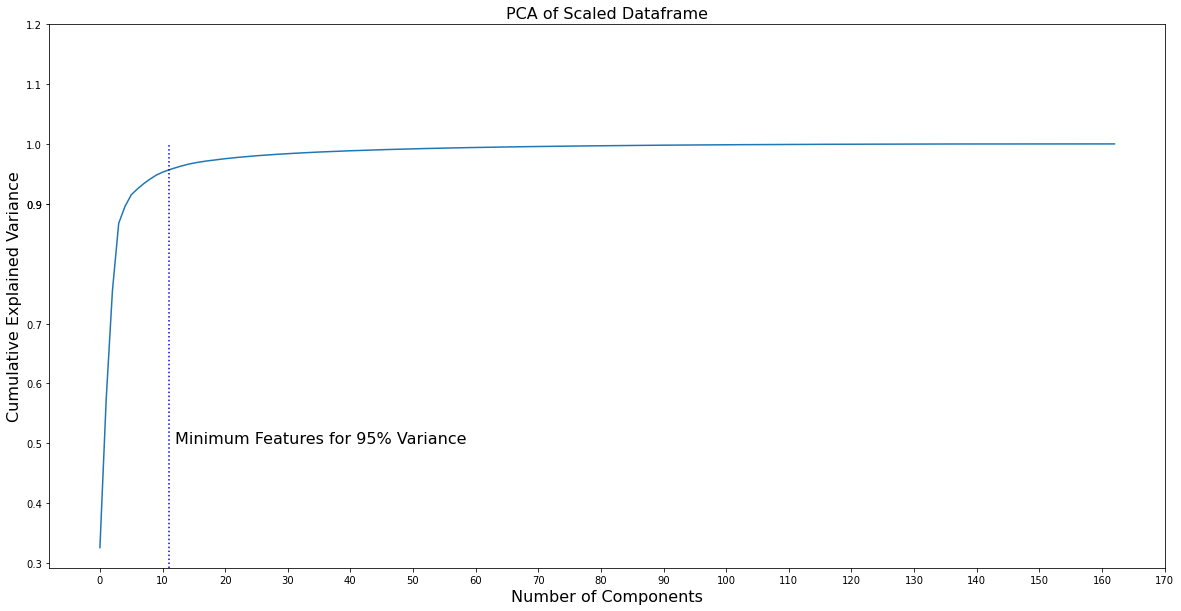

In [27]:
pca_scaled = PCA().fit(scaled_df) # creating PCA of scaled dataframe

fig3, ax3 = plt.subplots(figsize=(20,10)) # assigning axis and figure size of plot

fig3 = plt.plot(np.cumsum(pca_scaled.explained_variance_ratio_)) # creating plot of cumulative variance vs number of components
ax3.set_title('PCA of Scaled Dataframe', fontsize = 16) # titling plot
ax3.set_xlabel('Number of Components', fontsize = 16) # labelling x axis of plot
ax3.set_ylabel('Cumulative Explained Variance', fontsize = 16) # labelling y axis of plot
ax3.set_yticks([0.3,0.4,0.5,0.6,0.7,0.9,0.9,1,1.1,1.2]) # setting yticks
ax3.set_xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170])


ax3.axvline(min_features, linestyle=':', color =  'b', ymin = 0, ymax = 0.78) # labeling mean
ax3.text(min_features + 1, 0.5, 'Minimum Features for 95% Variance', rotation = 0, fontsize = 16)

This curve quantifies how much of the total 164-dimensional variance is contained within the number of components.

To examine whether our decision to transform the dataset by standardizing our data in the range of 0 - 1 was justified, we can implement PCA on the original dataset and compare the difference.

In [28]:
pca_org_data = PCA().fit(scania_df2) # creating PCA of not scaled dataframe

percent_variance = 0.95
i = 0
while ( (np.cumsum(pca_org_data.explained_variance_ratio_)[i]) <= percent_variance):
        i += 1

min_features_org_data = i + 1 # adding 1 to minimum features as 0 is index
print(f'The minimum number of feature components required to keep 95% of the variance is {min_features_org_data} feature.')

print(f'{min_features_org_data} feature retains {(np.cumsum(pca_org_data.explained_variance_ratio_)[i])}% of the variance in our original dataset.')

The minimum number of feature components required to keep 95% of the variance is 1 feature.
1 feature retains 0.9742341934929885% of the variance in our original dataset.


Before the data was normalised, PCA informs us that we can retain 97% of the data with only one feature. This is because PCA determines variance, and there was a high amount of variance in our original dataset. By comparing the results of our two PCA's, we can determine that by normalizing the data we are able to get a more accurate measure of the minimum required variables.

Text(2, 0.5, 'Minimum Features')

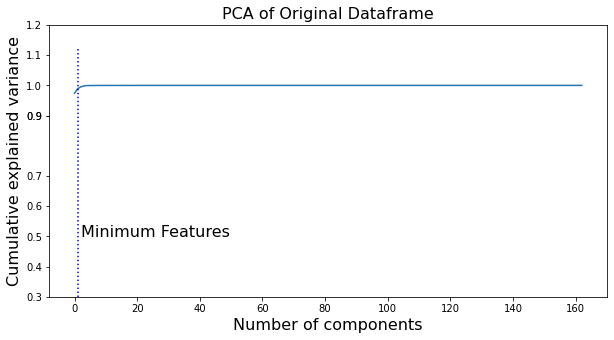

In [29]:
pca_org_data = PCA().fit(scania_df2)

fig5, ax5 = plt.subplots(figsize=(10,5)) # assigning axis and figure size of plot

fig5 = plt.plot(np.cumsum(pca_org_data.explained_variance_ratio_)) # creating plot of cumulative variance vs number of components
ax5.set_title('PCA of Original Dataframe', fontsize = 16) # titling plot
ax5.set_xlabel('Number of components', fontsize = 16) # labelling x axis of plot
ax5.set_ylabel('Cumulative explained variance', fontsize = 16) # labelling y axis of plot
ax5.set_yticks([0.3,0.4,0.5,0.6,0.7,0.9,0.9,1,1.1,1.2])

ax5.axvline(min_features_org_data, linestyle=':', color =  'b', ymin = 0, ymax = 0.92) # labeling mean
ax5.text(2, 0.5, 'Minimum Features', rotation = 0, fontsize = 16)

## PCA for Dimensionality Reduction.

From our graph we can read the number of components needed to keep the maximal variance in our data. We can then use PCA to project the data into that number of dimensions.

In [30]:
pca = PCA(n_components=min_features) # creating PCA to the minimum components
pca.fit(scaled_df) # fitting PCA to our dataframe
scaled_pca  = pca.transform(scaled_df) # creating new transformed dataframe


print('Original Shape: ', scaled_df.shape)
print('Transformed shape: ', scaled_pca.shape)

Original Shape:  (60000, 163)
Transformed shape:  (60000, 11)


We can see using PCA, the shape of the dataframe has retained each element with 60,000 rows, but the number of features has been reduced from 163 to 11. PCA retains the maximum possible information in the first component, then the maximum possible in the second, and so on to allow for greater reduced dimensionality. If most of the variance can be captured with only the first few components, we could drop the rest and still retain the majority of the information. To visualize this, we can draw a bar chart of each components percentage of explained variance.

Text(0, 0.5, 'Proportion of Variance Explained')

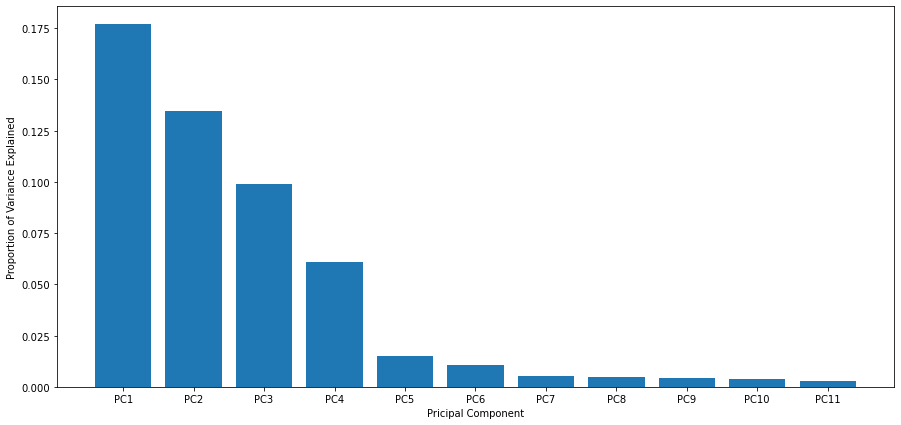

In [31]:
pca_df = pd.DataFrame(scaled_pca) # converting pca to dataframe
pca_df.insert(0, 'Class', scania_df['class'], True) # adding class row

pca = PCA(n_components=11) # defining PCA
pca.fit(scaled_df)
scaled_pca  = pca.transform(scaled_df)

var = pca.explained_variance_[0:11] #percentage of variance explained
labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11']

plt.figure(figsize=(15,7)) # plotting graph of principle components variance
plt.bar(labels,var,)
plt.xlabel('Pricipal Component')
plt.ylabel('Proportion of Variance Explained')

In [32]:
print(f'The first 3 components account for {round((pca.explained_variance_[0:3].sum())*100, 2)}% of the variance.')

The first 3 components account for 41.03% of the variance.


From the graph we can see that the first component accounts for the most variance, at roughly 17%. Each consecutive component from the first consists of a step less. However while the variance of the first few components are proportionally larger than the rest, the first 3 components combined only account for 41% of the total variance, and so to retain adequate information we cannot discard any one component.

Another way to evaluate our PCA is to see if it had any effect in distinguishing the different classes in our dataset. From the descriptor, we can see that the dataset is split into a positive and negative class, positive for component failures related to the APS system, and negative for component failures unrelated to the APS.

We can create a scatter plot with some of the principal components, and colour the different classes. We can then look for patterns in the scatter, to see if our principal components contain enough information to classify the two classes. In this case we are going to label the positive class with blue, and the negative class with red. If for instance the blue points form a cluster on the scatter plot, this would be an indication that our principal components contain enough variance information to classify the data (Jaadi).

As we saw from our bar chart, the first component contains the most explained variance, and each consecutive component retains progressively less explained variance. Because of this we will plot the first component, vs the second and third to capture as much variance as possible with only 2 principal components.

In [33]:
pca_df # examining pca dataframe

,Class,0,1,2,3,4,5,6,7,8,9,10
0,neg,0.405763,0.730854,0.242856,0.104167,0.068785,-0.106463,0.012730,-0.057545,-0.026352,-0.025559,0.021972
1,neg,0.127928,-0.198444,0.011671,-0.109456,-0.662431,-0.187457,0.024140,0.044429,0.002443,-0.011243,0.007358
2,neg,-0.189538,-0.069857,-0.198131,-0.053269,-0.013202,0.117435,-0.000487,-0.001472,0.041482,-0.000197,-0.006421
3,neg,-0.470993,-0.039765,-0.130322,-0.042847,0.007219,0.005071,0.001881,0.008498,-0.013654,-0.001471,0.003136
4,neg,0.257739,-0.207098,-0.052783,-0.056552,0.028248,-0.054008,0.006436,-0.007139,0.060998,-0.013400,0.008749
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,0.856174,-0.309013,-0.096752,-0.008938,0.031681,-0.112808,0.035898,-0.050440,0.009640,-0.033306,-0.018270
59996,neg,-0.155223,0.847407,0.233258,0.004245,0.005923,0.010167,-0.003381,0.012009,-0.009667,0.001273,0.000509
59997,neg,-0.269349,0.876702,0.208733,0.024073,0.008372,0.014982,-0.003819,0.011028,-0.011100,0.000587,0.004584
59998,neg,-0.173447,0.888107,0.094673,0.205005,0.042499,-0.061546,0.019294,-0.076733,-0.052901,-0.040769,0.018838


Text(0.5, 1.0, 'Scatter of PC 1 vs PC 2 with colour difference for class')

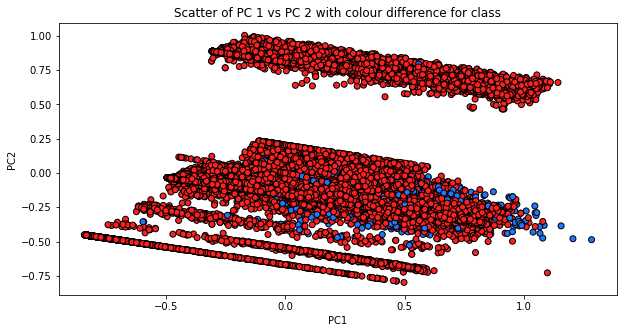

In [34]:
fig6, ax6 = plt.subplots(figsize=(10,5)) # assigning axis and figure size of plot
colour = ['#ff2121' if y == 'neg' else '#2176ff' for y in pca_df.iloc[:, 0]]
fig6 = plt.scatter(pca_df.iloc[:, 1], pca_df.iloc[:, 2], c=colour, edgecolors='#000000')
ax6.set_xlabel('PC1')
ax6.set_ylabel('PC2')
ax6.set_title('Scatter of PC 1 vs PC 2 with colour difference for class')

Text(0, 0.5, 'PC3')

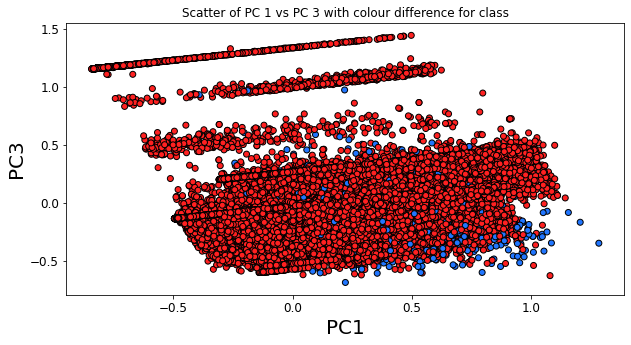

In [35]:
fig6, ax6 = plt.subplots(figsize=(10,5)) # assigning axis and figure size of plot
colour = ['#ff2121' if y == 'neg' else '#2176ff' for y in pca_df.iloc[:, 0]]
fig6 = plt.scatter(pca_df.iloc[:, 1], pca_df.iloc[:,3], c=colour, edgecolors='#000000')
ax6.set_title('Scatter of PC 1 vs PC 3 with colour difference for class')
plt.ylabel("Glucose",size=20)
plt.xlabel('Age',size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC3')

Text(0, 0.5, 'PC4')

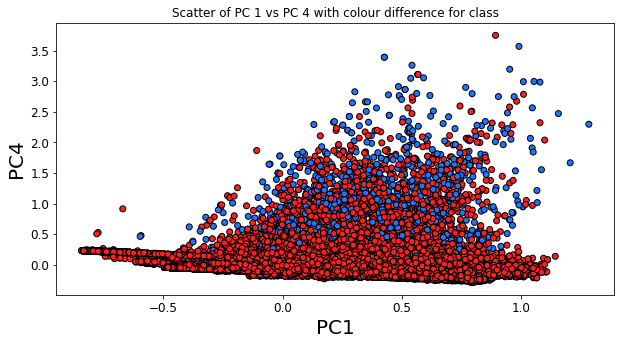

In [36]:
fig6, ax6 = plt.subplots(figsize=(10,5)) # assigning axis and figure size of plot
colour = ['#ff2121' if y == 'neg' else '#2176ff' for y in pca_df.iloc[:, 0]]
fig6 = plt.scatter(pca_df.iloc[:, 1], pca_df.iloc[:,4], c=colour, edgecolors='#000000')
ax6.set_title('Scatter of PC 1 vs PC 4 with colour difference for class')
plt.ylabel("Glucose",size=20)
plt.xlabel('Age',size=20)
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC4')

## Conclusions

From the scatter plots there are no distinct clusters that would allow us to simply identify a positive from an unlabelled negative class. This is not too surprising, from our bar chart of explained variance we saw that the first 3 components only contained 41% of the variance, so it is unsurprising that distinct clusters could not be identified from only plotting 2 principal components. As we can only plot in two dimensions, we are limited to examining 2 principal components at a time. A more accurate way of checking the accuracy of our PCA would be a classification machine learning algorithm.

Data preparation by way of removing missing values, dropping columns with little information and converting data types were important steps in preparing the data for analysis. Next by examining the variance, we could determine that the data should be normalized before applying analysis. We saw from comparing the PCA of the dataframe before normalization, and after, that we got a more accurate result with more components than before the data was normalized. From this we can conclude that data preparation is extremely important before conducting analysis. If we want accurate models with predictive results, the data fed into our models must be of proper quality and format.

PCA is a powerful tool in simplifying a dataset, while retaining the important signal of information in the data. We were able to reduce the number of features from 163 to 11, while still retaining as much variance as possible. This makes PCA a powerful tool when dealing with data that would otherwise be heavily affected by the curse of dimensionality.